# Time series forecasting fundamentals and BitPredict project

In this notebook I'll cover fundamentals of time series with TensorFlow and create project BitPredict which will predict price of bitcoin based on historical data.

## Data

Source of data is [CoinDesk](https://www.coindesk.com/price/bitcoin/)

In [1]:
# load data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

df = pd.read_csv("./data/11_Timeseries_and_Bitpredict/BTC_USD_2014-11-02_2021-09-27-CoinDesk.csv")
df.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2014-11-02,325.22633,338.01050,338.12950,319.36700
1,BTC,2014-11-03,331.60083,325.22633,333.75983,319.04350
2,BTC,2014-11-04,324.71833,331.60083,332.75133,323.06333
3,BTC,2014-11-05,332.45666,324.71833,335.81166,320.93333
4,BTC,2014-11-06,336.58500,332.45666,341.49000,328.56166


In [2]:
# get rid of 24h columns
df = pd.DataFrame(df, columns = ["Date", "Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
df.head()

,Date,Price
0,2014-11-02,325.22633
1,2014-11-03,331.60083
2,2014-11-04,324.71833
3,2014-11-05,332.45666
4,2014-11-06,336.58500


<AxesSubplot:>

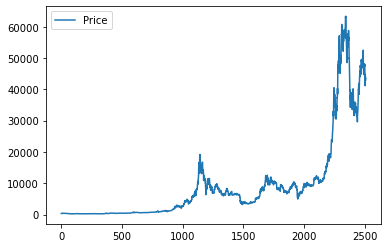

In [3]:
df.plot()

Doing the same, but using python's csv module instead of Pandas

In [4]:
import csv
from datetime import datetime

In [5]:
timesteps = []
btc_price = []

with open('./data/11_Timeseries_and_Bitpredict/BTC_USD_2014-11-02_2021-09-27-CoinDesk.csv', "r") as f:
    csv_reader = csv.reader(f, delimiter=",")
    next(csv_reader)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
        btc_price.append(float(line[2]))

timesteps = np.array(timesteps)
btc_price = np.array(btc_price)
        
timesteps[:5]

array([datetime.datetime(2014, 11, 2, 0, 0),
       datetime.datetime(2014, 11, 3, 0, 0),
       datetime.datetime(2014, 11, 4, 0, 0),
       datetime.datetime(2014, 11, 5, 0, 0),
       datetime.datetime(2014, 11, 6, 0, 0)], dtype=object)

In [6]:
btc_price[:5]

array([325.22633, 331.60083, 324.71833, 332.45666, 336.585  ])

In [7]:
len(btc_price), len(timesteps)

(2507, 2507)

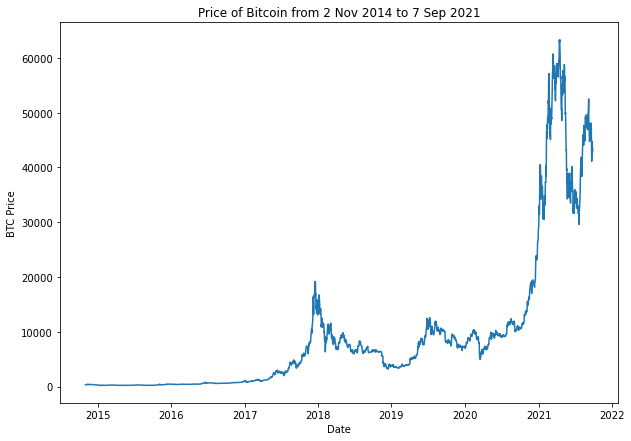

In [8]:
# import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 2 Nov 2014 to 7 Sep 2021")
plt.xlabel("Date");

### Format Data Part 1

#### Create train and test splits


In [9]:
split_size = int(0.80 * len(btc_price))

X_train, y_train = timesteps[:split_size], btc_price[:split_size]
X_test, y_test = timesteps[split_size:], btc_price[split_size:]

In [10]:
# function for ploting
def plot_time_series(timesteps, values, pointer_style=".", start=0, end=None, label=None):
    """
    PLots timesteps vs values
    
    Parameters
    ----------
    timesteps : array of timestep values
    values : array of values across time
    pointer_style : style of plot, default "."
    start : where to start the plot
    end: where to end plot
    label : label to show on plot about values
    """
    # plot_time_series
    plt.plot(timesteps[start:end], values[start:end], pointer_style, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

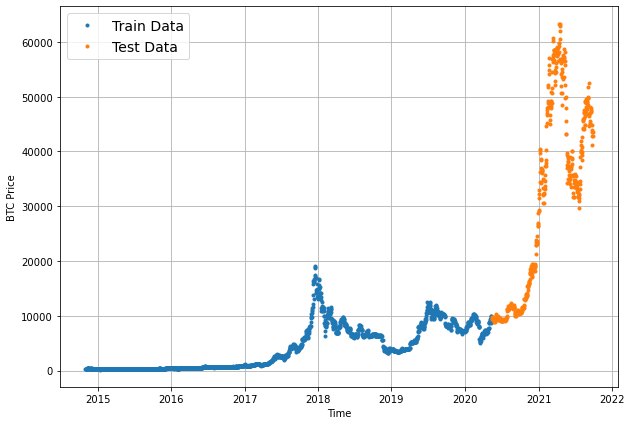

In [11]:
plt.figure(figsize=(10, 7))
plot_time_series(X_train, y_train, label="Train Data")
plot_time_series(X_test, y_test, label="Test Data")

## Modeling experimets

### Model 0: Naive Forecast (baseline)

The formula looks like this
$$\hat{y}_{t} = y_{t-1}$$

In english
> The prediction at timestep t (y-hat) is equal to that value at timestep t-1 (previous timestep) - this is for horizon of 1.

In [12]:
# Create a navive forecast
naive_forecast = np.array(y_test[:-1])
naive_forecast[:10], naive_forecast[-10:]

(array([9330.9864847 , 9757.29658559, 9362.63555697, 9418.91855051,
        9684.70195935, 9723.68015045, 9719.48085448, 9540.88656658,
        9141.15063742, 9192.84513581]),
 array([47648.50198766, 47305.80539102, 48020.75632612, 47128.93517747,
        43831.21476818, 41139.26285124, 43478.47111186, 44755.57192989,
        42877.95560002, 42771.92799784]))

In [13]:
y_test[-10:]

array([47305.80539102, 48020.75632612, 47128.93517747, 43831.21476818,
       41139.26285124, 43478.47111186, 44755.57192989, 42877.95560002,
       42771.92799784, 43572.08488608])

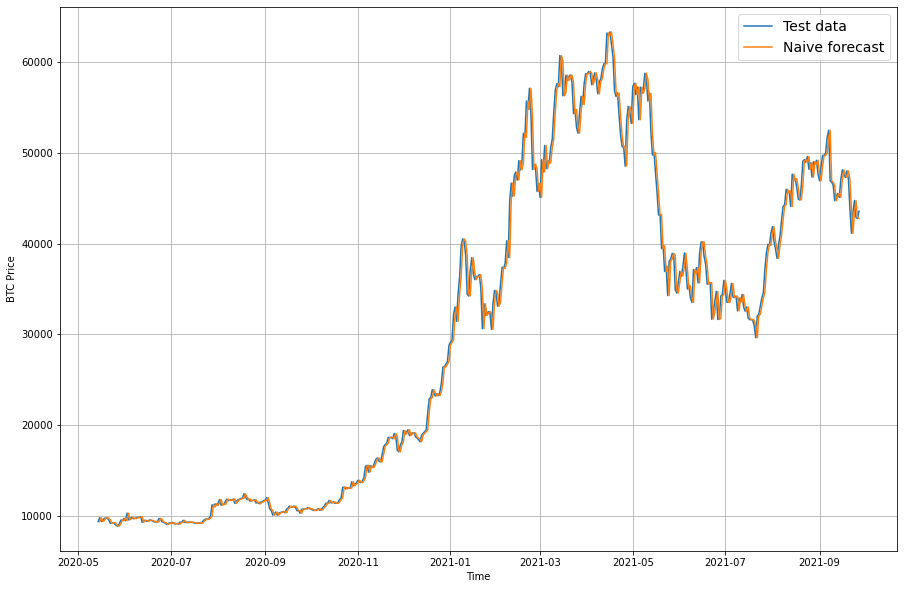

In [14]:
plt.figure(figsize=(15,10))
# plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test,"-", label="Test data")
plot_time_series(X_test[1:],naive_forecast,"-",  label="Naive forecast")


### Evaluating a time series model

Since we re predicting a nubmber here, reggression metrics apply here and there are also Time Series specific evaluation metrics like MAPE/sMAPE and MSAE.

We are going to use:
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean squared log error
* MAPE/sMAPE - scaled mean absolute prcentage error
* MASE - mean absolute scaled error

For all of them **lower is better**.

In [15]:
import tensorflow as tf
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implements MASE
    """
    e = y_true-y_pred # calculates error for all predictions
    # part under division line
    x =(tf.reduce_sum(tf.abs(y_true[1:] - y_true[:-1])) /(len(y_true) - 1))
    # calculates scaled error for all predictions
    q = e / x 
    
    return tf.reduce_mean(tf.abs(q))  # returns MASE

In [16]:
mean_absolute_scaled_error(y_test[1:], naive_forecast)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9989825607367834>

In [17]:
# function to evaluate mnodels
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy(),
            "rmse": rmse.numpy()}

In [18]:
naive_results = evaluate_preds(y_test[1:], naive_forecast)
naive_results

{'mae': 2.6092222,
 'mse': 868.6693,
 'mape': 2.6092222,
 'mase': 0.99898267,
 'rmse': 29.473196}

### Format Data Part 2: Windowing dataset

In [19]:
# Global variables for window and horizon size
HORIZON = 1 # predict next one day
WINDOW_SIZE = 7 # use the past week if Bitcoin data to make the predictions

def get_labeled_windows(x, horizon=HORIZON):
    """
    Creates labels fow windowed dataset
    """
    return x[:, :-horizon], x[:, -horizon]

In [20]:
# Test out the window labeling function
test_window, test_label = get_labeled_windows(tf.expand_dims(tf.range(8), axis=0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6]])>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([7])>)

In [21]:
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array into a 2D array of sequential labeled windows of
    window_size with horizons size labels.
    """
    # 1. Create a window of specific window_size (add the horizon on the end for labeling later)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    # 2. Use numpy indexing to create a 2D array of multiple window steps
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T
    # 3. Index on the target array (a time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]
    # 4. Get the labeled windows
    windows, labels = get_labeled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [22]:
full_windows, full_labels = make_windows(btc_price)
len(full_windows)

2500

In [23]:
for i in range(5):
    print(full_windows[i], full_labels[i])

[325.22633 331.60083 324.71833 332.45666 336.585   346.775   344.81166] 343.065
[331.60083 324.71833 332.45666 336.585   346.775   344.81166 343.065  ] 358.50166
[324.71833 332.45666 336.585   346.775   344.81166 343.065   358.50166] 368.07666
[332.45666 336.585   346.775   344.81166 343.065   358.50166 368.07666] 376.99666
[336.585   346.775   344.81166 343.065   358.50166 368.07666 376.99666] 442.10666


In [24]:
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    
    return train_windows, test_windows, train_labels, test_labels
    

In [25]:
train_windows, test_windows, train_labels, test_labels= make_train_test_splits(full_windows, full_labels)

In [26]:
len(train_windows), len(test_windows)

(2000, 500)

In [27]:
train_labels[:5].shape

(5,)

In [28]:
# Check to see of train labels are the same before and after window split
np.array_equal(train_labels[:-HORIZON-1], y_train[WINDOW_SIZE:])

True

In [29]:
from utils import create_checkpoint_callback
CHEKPOINTS_DIR = "./checkpoints/11_Timeseries_and_Bitpredict/"

In [30]:
## Model 1: Dense model (window=7, horizon =1)

import tensorflow as tf
from tensorflow.keras import layers, Sequential

# Set radnom state
tf.random.set_seed(42)

model_1 = Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_1_dense")

model_1.compile(loss="mae",
               optimizer="adam",
               metrics=["mae", "mse"])

callbacks = [create_checkpoint_callback(CHEKPOINTS_DIR+"/model_1_dense/chekpoint.ckpt",
                                       best_only=True, weights_only=True, metric="val_mae")]

In [31]:
# model_1.fit(train_windows,
#            train_labels,
#            epochs=100,
#             verbose=1,
#             batch_size=128,
#             validation_data=(test_windows,test_labels),
#             callbacks=callbacks
#            )

In [32]:
model_1.load_weights(CHEKPOINTS_DIR +"/model_1_dense/chekpoint.ckpt")
model_1_preds = model_1.predict(test_windows)
model_1_results = evaluate_preds(test_labels, tf.squeeze(model_1_preds))
model_1_results

{'mae': 2.6269577,
 'mse': 879.65265,
 'mape': 2.6269577,
 'mase': 1.0105078,
 'rmse': 29.65894}

In [33]:
naive_results

{'mae': 2.6092222,
 'mse': 868.6693,
 'mape': 2.6092222,
 'mase': 0.99898267,
 'rmse': 29.473196}

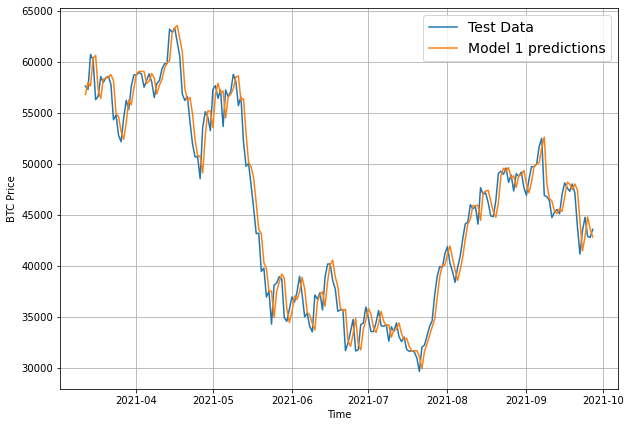

In [34]:
# PLot model_1 predictions
offset = 300
plt.figure(figsize=(10,7))
# Account for the test_window offset and index into test_labels to ensure correct plotting 
plot_time_series(X_test[-len(test_windows):], values=test_labels[:]
                 ,start=offset, label="Test Data", pointer_style="-")
plot_time_series(X_test[-len(test_windows):], values=tf.squeeze(model_1_preds),
                 start=offset, label="Model 1 predictions", pointer_style="-")

### Model 2: Dense (window = 30, horizon = 1)

In [35]:
HORIZON = 1
WINDOW_SIZE = 30
full_windows, full_labels = make_windows(btc_price, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,
                                                                                  full_labels)

In [36]:
## Model 2: Dense model (window=30, horizon =1)

import tensorflow as tf
from tensorflow.keras import layers, Sequential

# Set radnom state
tf.random.set_seed(42)

model_2 = Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_1_dense")

model_2.compile(loss="mae",
               optimizer="adam",
               metrics=["mae", "mse"])

callbacks = [create_checkpoint_callback(CHEKPOINTS_DIR+"/model_2_dense/chekpoint.ckpt",
                                       best_only=True, weights_only=True, metric="val_mae")]

In [37]:
# model_2.fit(train_windows,
#            train_labels,
#            epochs=100,
#             verbose=1,
#             batch_size=128,
#             validation_data=(test_windows,test_labels),
#             callbacks=callbacks
#            )

In [38]:
model_2.load_weights(CHEKPOINTS_DIR +"/model_2_dense/chekpoint.ckpt")
model_2_preds = model_2.predict(test_windows)
model_2_results = evaluate_preds(test_labels, tf.squeeze(model_2_preds))
model_2_results

{'mae': 2.834177,
 'mse': 950.3504,
 'mape': 2.834177,
 'mase': 1.0838823,
 'rmse': 30.827753}

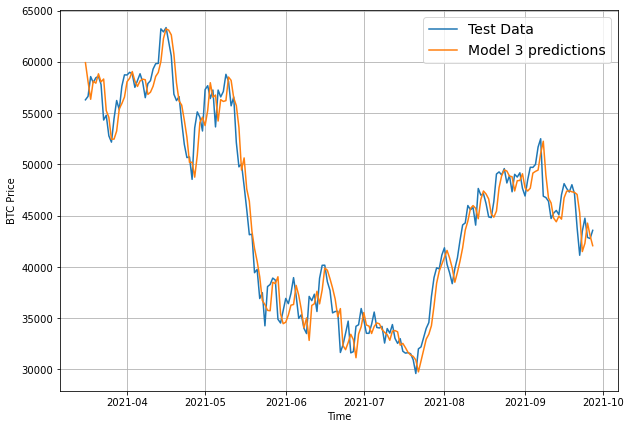

In [39]:
offset = 300
plt.figure(figsize=(10,7))
# Account for the test_window offset and index into test_labels to ensure correct plotting 
plot_time_series(X_test[-len(test_windows):], values=test_labels[:]
                 ,start=offset, label="Test Data", pointer_style="-")
plot_time_series(X_test[-len(test_windows):], values=tf.squeeze(model_2_preds),
                 start=offset, label="Model 3 predictions", pointer_style="-")

In [40]:
# visualize predictions

def visualuze_metrics(metrics_dicts, names_of_models, figsize=(6, 6), metric="mae"):
    import matplotlib.pyplot as plt
    %matplotlib inline
    df_metrics = pd.DataFrame.from_dict(metrics_dicts)
    df_metrics.index = names_of_models
    df_metrics = pd.DataFrame(df_metrics[metric])
    df_metrics.plot.bar(figsize=figsize)
    plt.xticks(c="white", rotation="horizontal")
    plt.yticks(c="white");
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

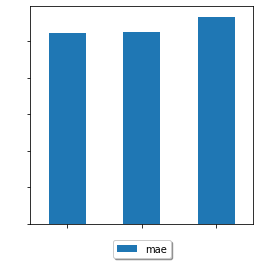

In [41]:
visualuze_metrics([naive_results, model_1_results, model_2_results],
                 ["Naive forecast", "Model 1", "Model 2"], figsize=(4,4))

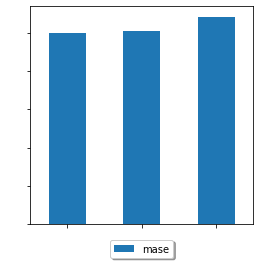

In [42]:
visualuze_metrics([naive_results, model_1_results, model_2_results],
                 ["Naive forecast", "Model 1", "Model 2"],figsize=(4,4),
                  metric="mase")

### Model 3: Dense (window = 30, horizon = 7)

In [43]:
HORIZON = 7
WINDOW_SIZE = 30
full_windows, full_labels = make_windows(btc_price, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,
                                                                                  full_labels)

In [44]:
## Model 2: Dense model (window=30, horizon =1)

import tensorflow as tf
from tensorflow.keras import layers, Sequential

# Set radnom state
tf.random.set_seed(42)

model_3 = Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_1_dense")

model_3.compile(loss="mae",
               optimizer="adam",
               metrics=["mae", "mse"])

callbacks = [create_checkpoint_callback(CHEKPOINTS_DIR+"/model_3_dense/chekpoint.ckpt",
                                       best_only=True, weights_only=True, metric="val_mae")]

In [45]:
# model_3.fit(train_windows,
#            train_labels,
#            epochs=100,
#             verbose=1,
#             batch_size=128,
#             validation_data=(test_windows,test_labels),
#             callbacks=callbacks
#            )

In [46]:
model_3.load_weights(CHEKPOINTS_DIR +"/model_3_dense/chekpoint.ckpt")
model_3_preds = tf.reduce_mean(model_3.predict(test_windows), axis=1)
model_3_results = evaluate_preds(test_labels, tf.squeeze(model_3_preds))
model_3_results

{'mae': 2.879819,
 'mse': 955.71844,
 'mape': 2.879819,
 'mase': 1.1090949,
 'rmse': 30.914696}

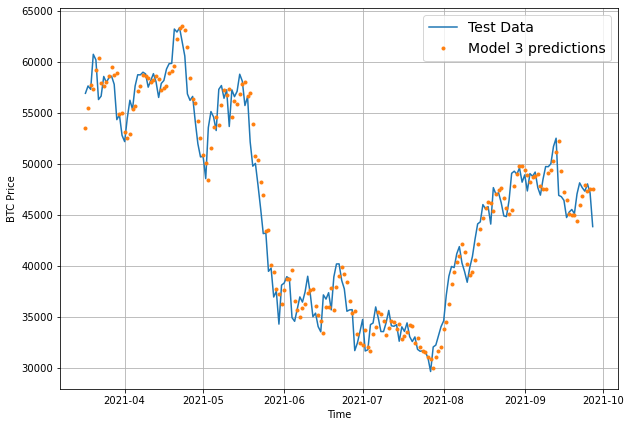

In [47]:
offset = 300
plt.figure(figsize=(10,7))
# Account for the test_window offset and index into test_labels to ensure correct plotting 
plot_time_series(X_test[-len(test_windows):], values=test_labels[:]
                 ,start=offset, label="Test Data", pointer_style="-")
plot_time_series(X_test[-len(test_windows):], values=model_3_preds,
                 start=offset, label="Model 3 predictions", pointer_style=".")

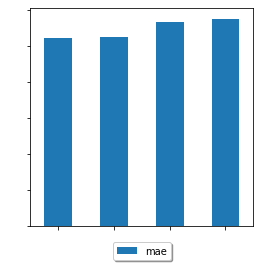

In [48]:
visualuze_metrics([naive_results, model_1_results, model_2_results, model_3_results],
                 ["Naive forecast", "Model 1", "Model 2", "Model 3"], figsize=(4,4))

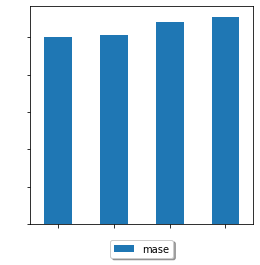

In [49]:
visualuze_metrics([naive_results, model_1_results, model_2_results, model_3_results],
                 ["Naive forecast", "Model 1", "Model 2", "Model 3"], figsize=(4,4), metric="mase")

### Model 4: Conv1D

In [50]:
HORIZON = 1
WINDOW_SIZE = 7

In [51]:
full_windows, full_labels = make_windows(btc_price, WINDOW_SIZE, HORIZON)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,
                                                                                  full_labels)

In [52]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [53]:
x = tf.constant(train_windows[0])
# Testing layer
print(f"Orginal shape: {x.shape}")
print(f"EXpandes shape: {expand_dims_layer(x).shape}")
print(f"Tensor:\n{expand_dims_layer(x)}")

Orginal shape: (7,)
EXpandes shape: (7, 1)
Tensor:
[[325.22632]
 [331.60083]
 [324.71832]
 [332.45667]
 [336.585  ]
 [346.775  ]
 [344.81165]]


In [54]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(7,), dtype=tf.float64)
x = expand_dims_layer(inputs)
x = layers.Conv1D(128, 5, padding="same")(x)
outputs = layers.Dense(1)(x)

model_4 = tf.keras.Model(inputs, outputs)

model_4.compile(loss="mae",
               optimizer="adam",
               metrics=["mae", "mse"])

callbacks = [create_checkpoint_callback(CHEKPOINTS_DIR+"/model_4_conv1d/chekpoint.ckpt",
                                       best_only=True, weights_only=True, metric="val_mae")]

In [55]:
# model_4.fit(train_windows,
#            train_labels,
#            epochs=100,
#             verbose=1,
#             batch_size=128,
#             validation_data=(test_windows,test_labels),
#             callbacks=callbacks
#            )

In [56]:
model_4.load_weights(CHEKPOINTS_DIR +"/model_4_conv1d/chekpoint.ckpt")
model_4_preds = tf.reduce_mean(model_4.predict(test_windows), axis=1)
model_4_results = evaluate_preds(test_labels, tf.squeeze(model_4_preds))
model_4_results

{'mae': 2.6034267,
 'mse': 868.6336,
 'mape': 2.6034267,
 'mase': 0.99784964,
 'rmse': 29.472591}

In [57]:
naive_results

{'mae': 2.6092222,
 'mse': 868.6693,
 'mape': 2.6092222,
 'mase': 0.99898267,
 'rmse': 29.473196}

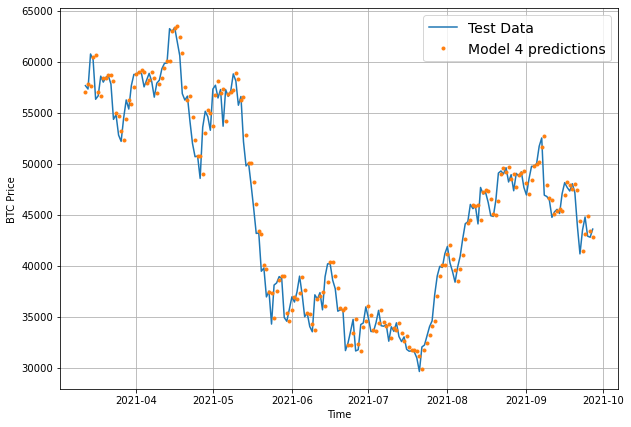

In [58]:
offset = 300
plt.figure(figsize=(10,7))
# Account for the test_window offset and index into test_labels to ensure correct plotting 
plot_time_series(X_test[-len(test_windows):], values=test_labels[:]
                 ,start=offset, label="Test Data", pointer_style="-")
plot_time_series(X_test[-len(test_windows):], values=model_4_preds,
                 start=offset, label="Model 4 predictions", pointer_style=".")

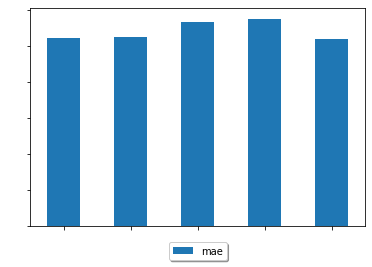

In [59]:
visualuze_metrics([naive_results, model_1_results, model_2_results, model_3_results, model_4_results],
                 ["Naive forecast", "Model 1", "Model 2", "Model 3", "Model 4"], figsize=(6,4))


### Model 5: RNN (LSTM)

In [60]:
inputs = layers.Input(shape=(7,))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
outputs = layers.Dense(1)(x)

model_5 = tf.keras.Model(inputs, outputs)

model_5.compile(loss="mae",
               optimizer="adam",
               metrics=["mae", "mse"])

callbacks = [create_checkpoint_callback(CHEKPOINTS_DIR+"/model_5_lstm/chekpoint.ckpt",
                                       best_only=True, weights_only=True, metric="val_mae")]

In [61]:
# model_5.fit(train_windows,
#            train_labels,
#            epochs=100,
#             verbose=1,
#             batch_size=128,
#             validation_data=(test_windows,test_labels),
#             callbacks=callbacks
#            )

In [62]:
model_5.load_weights(CHEKPOINTS_DIR +"/model_4_conv1d/chekpoint.ckpt")
model_5_preds = tf.reduce_mean(model_5.predict(test_windows), axis=1)
model_5_results = evaluate_preds(test_labels, tf.squeeze(model_5_preds))
model_5_results

{'mae': 96.64504,
 'mse': 28918.545,
 'mape': 96.64504,
 'mase': 33.2204,
 'rmse': 170.05453}

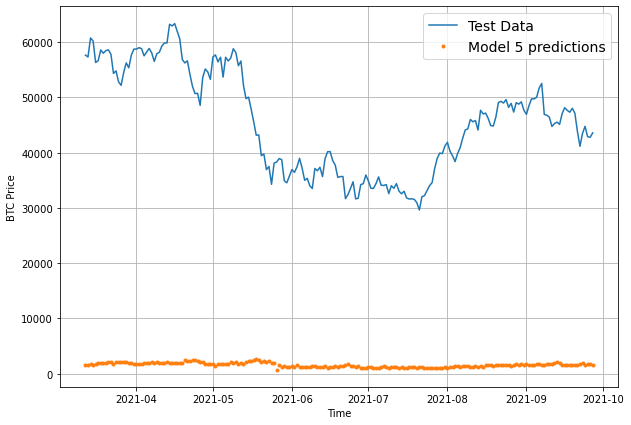

In [63]:
offset = 300
plt.figure(figsize=(10,7))
# Account for the test_window offset and index into test_labels to ensure correct plotting 
plot_time_series(X_test[-len(test_windows):], values=test_labels[:]
                 ,start=offset, label="Test Data", pointer_style="-")
plot_time_series(X_test[-len(test_windows):], values=model_5_preds,
                 start=offset, label="Model 5 predictions", pointer_style=".")

### Creating multivariate time series

In [64]:
block_reward_1 = 50 # 3 Jan 2009 - this block reward is not in our dataset
block_reward_2 = 25 # 28 nov 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Dates
block_reward_2_date = np.datetime64("2012-11-28")
block_reward_3_date = np.datetime64("2016-07-09")
block_reward_4_date = np.datetime64("2020-05-18")

In [65]:
df = pd.DataFrame((timesteps,btc_price), index=["Timesteps", "BTC prices"]).T
df.index = df.Timesteps
df.drop("Timesteps", axis=1, inplace=True)
df

,BTC prices
Timesteps,
2014-11-02,325.22633
2014-11-03,331.60083
2014-11-04,324.71833
2014-11-05,332.45666
2014-11-06,336.585
...,...
2021-09-23,43478.471112
2021-09-24,44755.57193
2021-09-25,42877.9556


In [66]:
# Create date ranges of where specific block_reward valus should be
block_reward_2_days = (block_reward_3_date - df.index[0]).days
block_reward_3_days = (block_reward_4_date - df.index[0]).days
block_reward_2_days, block_reward_3_days


(615, 2024)

In [67]:
# create a new df and add block reward column
bitcoin_prices_block = df.copy()
bitcoin_prices_block["Block_reward"] = None

In [68]:
# Add in block_reward values as a feature to our dataframe.
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [69]:
bitcoin_prices_block

,BTC prices,Block_reward
Timesteps,,
2014-11-02,325.22633,25
2014-11-03,331.60083,25
2014-11-04,324.71833,25
2014-11-05,332.45666,25
2014-11-06,336.585,25
...,...,...
2021-09-23,43478.471112,6.25
2021-09-24,44755.57193,6.25
2021-09-25,42877.9556,6.25


<AxesSubplot:xlabel='Timesteps'>

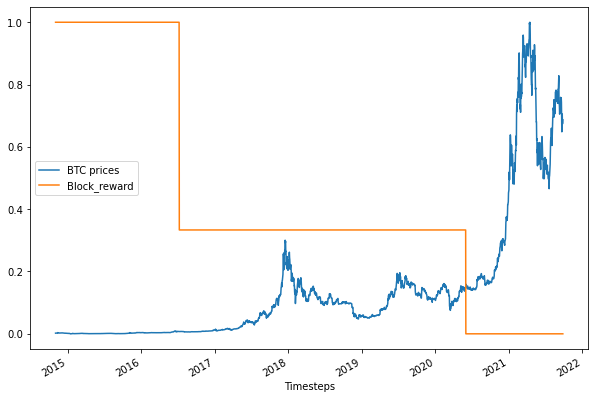

In [70]:
# plot
from sklearn.preprocessing import minmax_scale 
scaled_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["BTC prices", "Block_reward"]]),
                         columns=bitcoin_prices_block.columns,
                         index=bitcoin_prices_block.index
                        )
scaled_df.plot(figsize=(10,7))

#### Making windowed dataset with pandas

In [71]:
# Setup hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

bitcoin_prices_windowed = bitcoin_prices_block.copy()

In [72]:
# Add windowed columns
for i in range(WINDOW_SIZE):
    bitcoin_prices_windowed[f"BTC prices+{i+1}"] = bitcoin_prices_windowed["BTC prices"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,BTC prices,Block_reward,BTC prices+1,BTC prices+2,BTC prices+3,BTC prices+4,BTC prices+5,BTC prices+6,BTC prices+7
Timesteps,,,,,,,,,
2014-11-02,325.22633,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-03,331.60083,25,325.22633,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-04,324.71833,25,331.60083,325.22633,NaN,NaN,NaN,NaN,NaN
2014-11-05,332.45666,25,324.71833,331.60083,325.22633,NaN,NaN,NaN,NaN
2014-11-06,336.585,25,332.45666,324.71833,331.60083,325.22633,NaN,NaN,NaN
2014-11-07,346.775,25,336.585,332.45666,324.71833,331.60083,325.22633,NaN,NaN
2014-11-08,344.81166,25,346.775,336.585,332.45666,324.71833,331.60083,325.22633,NaN
2014-11-09,343.065,25,344.81166,346.775,336.585,332.45666,324.71833,331.60083,325.22633
2014-11-10,358.50166,25,343.065,344.81166,346.775,336.585,332.45666,324.71833,331.60083


In [73]:
bitcoin_prices_windowed.tail(10)

,BTC prices,Block_reward,BTC prices+1,BTC prices+2,BTC prices+3,BTC prices+4,BTC prices+5,BTC prices+6,BTC prices+7
Timesteps,,,,,,,,,
2021-09-18,47305.805391,6.25,47648.501988,48125.118784,47039.949931,45097.797218,45510.563249,45253.130625,44720.75555
2021-09-19,48020.756326,6.25,47305.805391,47648.501988,48125.118784,47039.949931,45097.797218,45510.563249,45253.130625
2021-09-20,47128.935177,6.25,48020.756326,47305.805391,47648.501988,48125.118784,47039.949931,45097.797218,45510.563249
2021-09-21,43831.214768,6.25,47128.935177,48020.756326,47305.805391,47648.501988,48125.118784,47039.949931,45097.797218
2021-09-22,41139.262851,6.25,43831.214768,47128.935177,48020.756326,47305.805391,47648.501988,48125.118784,47039.949931
2021-09-23,43478.471112,6.25,41139.262851,43831.214768,47128.935177,48020.756326,47305.805391,47648.501988,48125.118784
2021-09-24,44755.57193,6.25,43478.471112,41139.262851,43831.214768,47128.935177,48020.756326,47305.805391,47648.501988
2021-09-25,42877.9556,6.25,44755.57193,43478.471112,41139.262851,43831.214768,47128.935177,48020.756326,47305.805391
2021-09-26,42771.927998,6.25,42877.9556,44755.57193,43478.471112,41139.262851,43831.214768,47128.935177,48020.756326


In [74]:
X = bitcoin_prices_windowed.dropna().astype(np.float32)
y = X["BTC prices"]
X = X.drop("BTC prices", axis=1)

In [75]:
X

,Block_reward,BTC prices+1,BTC prices+2,BTC prices+3,BTC prices+4,BTC prices+5,BTC prices+6,BTC prices+7
Timesteps,,,,,,,,
2014-11-09,25.00,344.811646,346.774994,336.584991,332.456665,324.718323,331.600830,325.226318
2014-11-10,25.00,343.065002,344.811646,346.774994,336.584991,332.456665,324.718323,331.600830
2014-11-11,25.00,358.501648,343.065002,344.811646,346.774994,336.584991,332.456665,324.718323
2014-11-12,25.00,368.076660,358.501648,343.065002,344.811646,346.774994,336.584991,332.456665
2014-11-13,25.00,376.996674,368.076660,358.501648,343.065002,344.811646,346.774994,336.584991
...,...,...,...,...,...,...,...,...
2021-09-23,6.25,41139.261719,43831.214844,47128.933594,48020.757812,47305.804688,47648.503906,48125.117188
2021-09-24,6.25,43478.472656,41139.261719,43831.214844,47128.933594,48020.757812,47305.804688,47648.503906
2021-09-25,6.25,44755.570312,43478.472656,41139.261719,43831.214844,47128.933594,48020.757812,47305.804688


In [76]:
y

Timesteps
2014-11-09      343.065002
2014-11-10      358.501648
2014-11-11      368.076660
2014-11-12      376.996674
2014-11-13      442.106659
                  ...     
2021-09-23    43478.472656
2021-09-24    44755.570312
2021-09-25    42877.957031
2021-09-26    42771.929688
2021-09-27    43572.085938
Name: BTC prices, Length: 2500, dtype: float32

In [77]:
# create a train and test splits
BOUND = int(len(X) * 0.80)

X_train = X[:BOUND]
X_test = X[BOUND:]
y_train = y[:BOUND]
y_test = y[BOUND:]

In [78]:
len(X_train), len(X_test), len(X)

(2000, 500, 2500)

### Model 6: Dense + Multivariate data

In [79]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

# Set radnom state
tf.random.set_seed(42)

model_6 = Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_1_dense")

model_6.compile(loss="mae",
               optimizer="adam",
               metrics=["mae", "mse"])

callbacks = [create_checkpoint_callback(CHEKPOINTS_DIR+"/model_6_dense_multivariate/chekpoint.ckpt",
                                       best_only=True, weights_only=True, metric="val_mae")]

In [80]:
# model_6.fit(X_train,
#            y_train,
#            epochs=100,
#             verbose=1,
#             batch_size=128,
#             validation_data=(X_test, y_test),
#             callbacks=callbacks
#            )

In [81]:
model_6.load_weights(CHEKPOINTS_DIR +"/model_6_dense_multivariate/chekpoint.ckpt")
model_6_preds = tf.reduce_mean(model_6.predict(X_test), axis=1)
model_6_results = evaluate_preds(y_test, tf.squeeze(model_6_preds))
model_6_results

{'mae': 2.6068342,
 'mse': 871.27625,
 'mape': 2.6068342,
 'mase': 1.0008854,
 'rmse': 29.51739}

In [82]:
model_1_results

{'mae': 2.6269577,
 'mse': 879.65265,
 'mape': 2.6269577,
 'mase': 1.0105078,
 'rmse': 29.65894}

In [83]:
naive_results

{'mae': 2.6092222,
 'mse': 868.6693,
 'mape': 2.6092222,
 'mase': 0.99898267,
 'rmse': 29.473196}

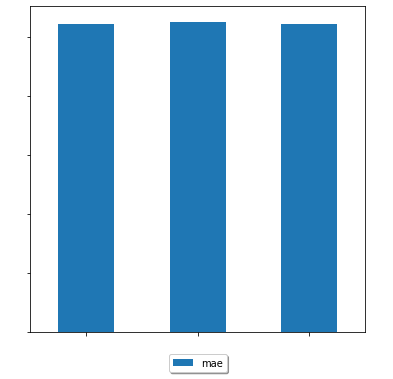

In [84]:
visualuze_metrics([naive_results, model_1_results, model_6_results],
                 ["Naive model", "Model 1", "Model 1 with multivariate data"])

### Model 7: N-BEATS algorithm

In [85]:
from tensorflow.keras.layers import Dense

# Create NBeatBLock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self,
                 input_size: int,
                 theta_size: int,
                 horizon: int,
                 n_neurons: int,
                 n_layers: int,
                 **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers
        # BLock contains starck of 4 FC layers and ReLU activation
        self.hidden = [Dense(n_neurons, activation="relu", name=f"dense_{i}") for i in range(4)]
        # Output of block is a theta layer with liner activation
        self.theta_layer = Dense(theta_size, activation="linear", name="theta")
    
    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)
        # Output
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

#### Prepare data paipeline

In [86]:
# Get rid of Block _reward
X = X.drop("Block_reward", axis=1)

In [87]:
# create a train and test splits
X_train = X[:BOUND]
X_test = X[BOUND:]
y_train = y[:BOUND]
y_test = y[BOUND:]

In [88]:
train_features = tf.data.Dataset.from_tensor_slices(X_train)
train_labels = tf.data.Dataset.from_tensor_slices(y_train)

test_features = tf.data.Dataset.from_tensor_slices(X_test)
test_labels = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features, train_labels))
test_dataset = tf.data.Dataset.zip((test_features, test_labels))


# Batch and prefetch 
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [89]:
train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float32, tf.float32)>)

#### Preparing hyperparameters from N-BEATS

In [90]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4 
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE
THETA_SIZE = INPUT_SIZE + HORIZON

#### Compiling the model

In [91]:
%%time 

tf.random.set_seed(42)

# 1. Setup instance of NBeatsBlock
nbeats_block = NBeatsBlock(input_size = INPUT_SIZE,
                     theta_size= THETA_SIZE,
                     horizon = HORIZON,
                     n_neurons = N_NEURONS,
                     n_layers = N_LAYERS,
                     name="InitialBLock")

# 2. Ceate an input to stack
input_stack = layers.Input(INPUT_SIZE, name="stack_input")

# 3. Create initial backcast and forecast input ()
residuals, forecast = nbeats_block(input_stack) 

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # First stack is already created
    backcast, block_forecast = NBeatsBlock(
                     input_size = INPUT_SIZE,
                     theta_size= THETA_SIZE,
                     horizon = HORIZON,
                     n_neurons = N_NEURONS,
                     n_layers = N_LAYERS,
                     name=f"NbeatsBlock_{i}")(residuals) # pass the resicuals
    # 6. Create the double residual stacking
    residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
    forecast = layers.add([forecast, block_forecast], name=f"add_{i}")
# 7. Put the model together
model_7 = tf.keras.Model(input_stack, forecast, name="NBEATS")

# 8. Compile model with MAE loss

model_7.compile(loss="mae",
               optimizer="adam")

# 9. Fit the model with EarlyStoping and ReduceLRonPlateau 
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=100,
                                             restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                patience=50,
                                                verbose=1)]

model_7.fit(train_dataset,
           epochs=N_EPOCHS,
           validation_data=test_dataset,
           verbose=0,
           callbacks=callbacks)


Epoch 00541: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00608: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00658: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Wall time: 3min 26s


In [92]:
!nvidia-smi

Thu Oct  7 08:50:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.41       Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0    34W /  N/A |   5053MiB /  6144MiB |     57%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [93]:
model_7_preds = tf.reduce_mean(model_7.predict(X_test), axis=1)
model_7_results = evaluate_preds(y_test, tf.squeeze(model_7_preds))
model_7_results, model_1_results, model_4_results, naive_results

({'mae': 2.6166382,
  'mse': 874.0583,
  'mape': 2.6166382,
  'mase': 1.0040811,
  'rmse': 29.564476},
 {'mae': 2.6269577,
  'mse': 879.65265,
  'mape': 2.6269577,
  'mase': 1.0105078,
  'rmse': 29.65894},
 {'mae': 2.6034267,
  'mse': 868.6336,
  'mape': 2.6034267,
  'mase': 0.99784964,
  'rmse': 29.472591},
 {'mae': 2.6092222,
  'mse': 868.6693,
  'mape': 2.6092222,
  'mase': 0.99898267,
  'rmse': 29.473196})

#### Ploting the N-BEATS architecture

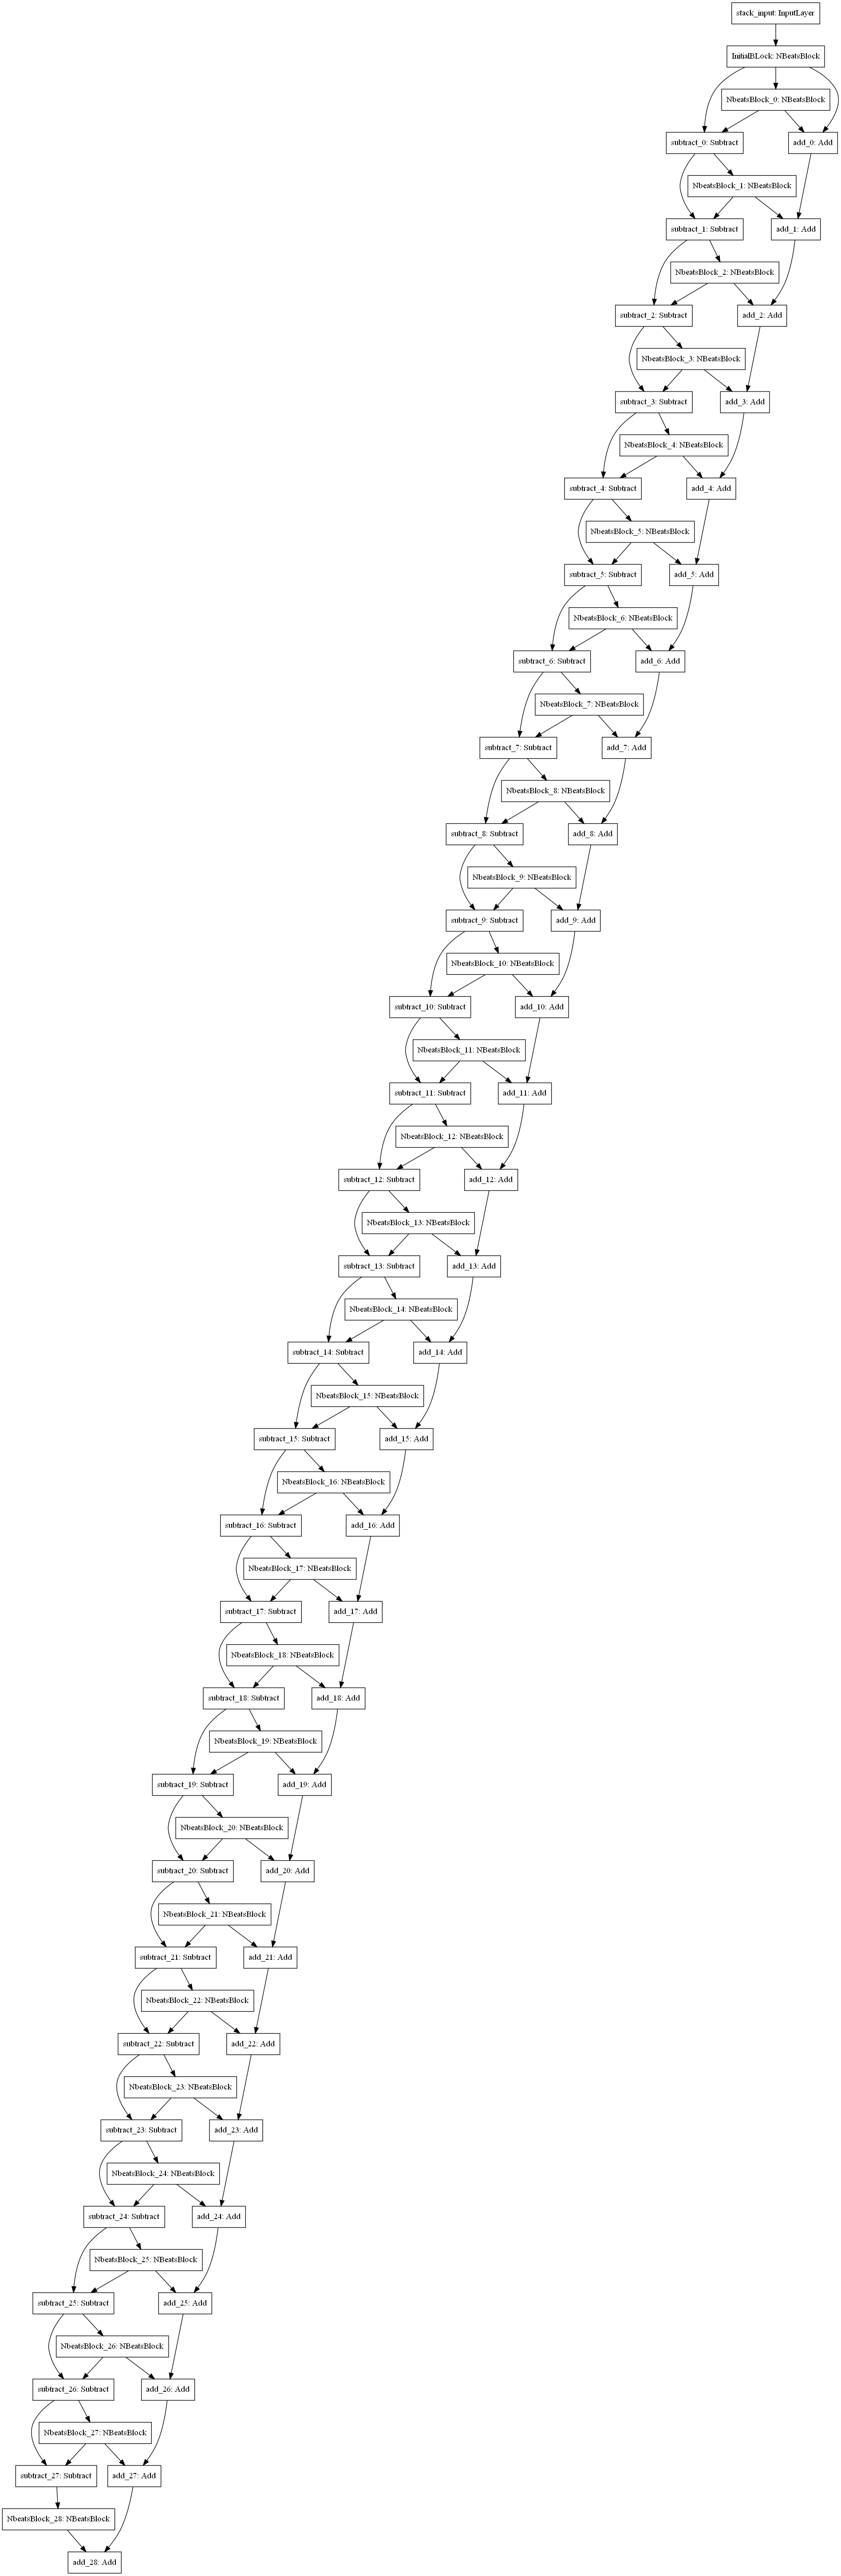

In [94]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

### Model 8: Create an ensemble of models (using different loss functions)

In [96]:
def get_ensemble_models(horizon=HORIZON,
                       train_data=train_dataset,
                       test_data=test_dataset,
                       num_iter=5,
                       num_epochs=1000,
                       loss_fns=["mae", "mse", "mape"]):
    # Make empty list for trained ensemble models
    ensemble_models = []

    # Create num_iter number of models per loss function
    for i in range(num_iter):
        # Build and fit a new model with a different loss functions
        for fn in loss_fns:
            print(f"Optimizing model by reducing: {fn} for {num_epochs} epochs, model nunber: {i}")

            # Construnct a simple model (similar to model_4)

            inputs = layers.Input(shape=(7,), dtype=tf.float64)
            x = expand_dims_layer(inputs)
            x = layers.Conv1D(128, 5, padding="same")(x)
            outputs = layers.Dense(1)(x)

            model = tf.keras.Model(inputs, outputs)

            model.compile(loss=fn,
                           optimizer="adam",
                           metrics=["mae", "mse"])

            callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=100,
                                                 restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                    patience=50,
                                                    verbose=1)]

            model.fit(train_data,
                      epochs=num_epochs,
                       validation_data=test_data,
                       verbose=0,
                       callbacks=callbacks)

            ensemble_models.append(model)
        
    return ensemble_models

In [97]:
%%time
ensemble_models = get_ensemble_models()

Optimizing model by reducing: mae for 1000 epochs, model nunber: 0
Optimizing model by reducing: mse for 1000 epochs, model nunber: 0
Optimizing model by reducing: mape for 1000 epochs, model nunber: 0

Epoch 00623: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00675: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00725: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model nunber: 1
Optimizing model by reducing: mse for 1000 epochs, model nunber: 1
Optimizing model by reducing: mape for 1000 epochs, model nunber: 1

Epoch 00554: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00625: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00675: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model nunber: 2
Optimizing model by reducing: mse for

In [98]:
def make_ensemble_preds(models, data):
    ensemble_preds = []
    for model in models:
        ensemble_preds.append(model.predict(data))
    
    return ensemble_preds

In [99]:
ensemble_preds = make_ensemble_preds(ensemble_models, X_test.to_numpy())

In [100]:
def get_results_ensemble(y_true, preds):
    results = []
    for pred in preds:
        results.append(evaluate_preds(y_true, tf.squeeze(pred)))
    df = pd.DataFrame(results).mean()
    return pd.DataFrame(df, columns=["ensemble model"])

In [101]:
ensemble_result = get_results_ensemble(y_test.to_numpy(), ensemble_preds)
ensemble_result

,ensemble model
mae,2.609450
mse,870.793396
mape,2.609450
mase,1.000331
rmse,29.509073


In [102]:
model_4_results

{'mae': 2.6034267,
 'mse': 868.6336,
 'mape': 2.6034267,
 'mase': 0.99784964,
 'rmse': 29.472591}

In [103]:
naive_results

{'mae': 2.6092222,
 'mse': 868.6693,
 'mape': 2.6092222,
 'mase': 0.99898267,
 'rmse': 29.473196}

### Ploting prediction intervals

One way to get 95% confidence prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distibution is Normal/Gaussian, 95% of observations fall within 1.96 standard deviations of the mean)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in the  (3) to the mean/median of the predictions made in (1)

In [105]:
def get_upper_lower_bounds(preds): # 1. Take the predictions from a number of randomly initialized models
    
    # 2. Measure a standard deviation of the predictions
    interval = tf.math.reduce_std(preds, axis=0) * 1.96 # 3. multiply by 1.96
    
    # 4. Get the predictions mean
    preds_mean = tf.reduce_mean(preds, axis=0)
    lower, upper = preds_mean- interval, preds_mean + interval
    
    return lower, upper

In [117]:
lower, upper = get_upper_lower_bounds(tf.squeeze(ensemble_preds))
lower, upper

(<tf.Tensor: shape=(500,), dtype=float32, numpy=
 array([ 9685.434 ,  9404.867 ,  9386.954 ,  9624.24  ,  9720.328 ,
         9732.961 ,  9538.586 ,  9161.7705,  9153.793 ,  9186.914 ,
         9056.383 ,  8903.907 ,  8801.891 ,  9040.718 ,  9434.398 ,
         9444.263 ,  9641.351 ,  9450.975 , 10103.991 ,  9618.212 ,
         9596.172 ,  9772.9375,  9632.016 ,  9679.689 ,  9674.64  ,
         9771.985 ,  9784.896 ,  9842.075 ,  9315.704 ,  9388.204 ,
         9435.42  ,  9342.283 ,  9417.6455,  9454.436 ,  9463.189 ,
         9396.104 ,  9273.463 ,  9320.463 ,  9286.567 ,  9593.36  ,
         9622.198 ,  9335.739 ,  9239.317 ,  9144.006 ,  9033.2705,
         9063.562 ,  9144.131 ,  9142.649 ,  9209.628 ,  9100.745 ,
         9077.676 ,  9107.331 ,  9047.217 ,  9229.898 ,  9238.628 ,
         9423.019 ,  9267.074 ,  9215.227 ,  9224.286 ,  9251.672 ,
         9246.213 ,  9232.104 ,  9205.756 ,  9127.116 ,  9140.409 ,
         9155.263 ,  9175.588 ,  9162.318 ,  9340.185 ,  9505.626 ,

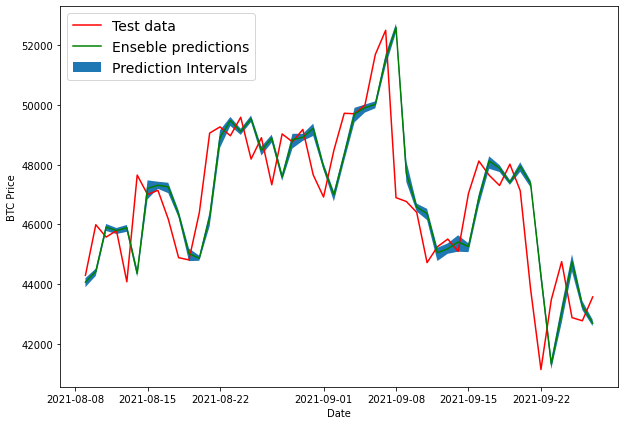

In [157]:
# Get then median values of ensemple preds
ensemble_median = np.median(tf.squeeze(ensemble_preds), axis=0)

# Plot the median of our ensemble preds along with the prediction intervals 
offset = 450
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:],"-", label="Test data", c="red")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "-", label="Enseble predictions", c="green")
plt.xlabel("Date")
plt.ylabel("BTC Price")

# To plot the upper and lower bounds, let's use fill_between method
plt.fill_between(X_test.index[offset:],
                lower[offset:],
                upper[offset:],
                label="Prediction Intervals")

plt.legend(loc="upper left", fontsize=14)

### Model 9: Why forecasting is a BS (the turkey problem)

In [158]:
# Let's introduce turkey problem in our data BTC data (price of BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

timesteps_turkey = timesteps.copy()

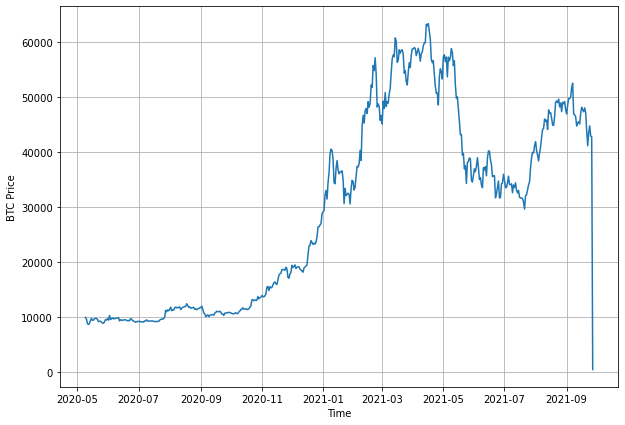

In [162]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps_turkey[2000:], btc_price_turkey[2000:], pointer_style="-")

In [173]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(btc_price_turkey, window_size=WINDOW_SIZE, horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels, test_split=0.2)
len(X_train), len(X_test)

(2000, 500)

In [174]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(7,), dtype=tf.float64)
x = expand_dims_layer(inputs)
x = layers.Conv1D(128, 5, padding="same")(x)
outputs = layers.Dense(1)(x)

model_9 = tf.keras.Model(inputs, outputs)

model_9.compile(loss="mae",
               optimizer="adam",
               metrics=["mae", "mse"])

callbacks = [create_checkpoint_callback(CHEKPOINTS_DIR+"/model_9_conv1d_turkey/chekpoint.ckpt",
                                       best_only=True, weights_only=True, metric="val_mae")]

In [175]:
model_4.fit(X_train,
           y_train,
           epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(X_test,y_test),
            callbacks=callbacks
           )

Epoch 1/100
16/16 [==============================] - 1s 20ms/step - loss: 242.4250 - mae: 242.4250 - mse: 241502.7500 - val_loss: 1635.8986 - val_mae: 1635.8986 - val_mse: 8933132.0000

Epoch 00001: val_mae improved from inf to 1635.89856, saving model to ./checkpoints/11_Timeseries_and_Bitpredict//model_9_conv1d_turkey\chekpoint.ckpt
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 211.7528 - mae: 211.7528 - mse: 192037.2188 - val_loss: 1439.5602 - val_mae: 1439.5602 - val_mse: 7591439.5000

Epoch 00002: val_mae improved from 1635.89856 to 1439.56018, saving model to ./checkpoints/11_Timeseries_and_Bitpredict//model_9_conv1d_turkey\chekpoint.ckpt
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 186.1533 - mae: 186.1533 - mse: 149394.0156 - val_loss: 1237.1260 - val_mae: 1237.1260 - val_mse: 6704678.0000

Epoch 00003: val_mae improved from 1439.56018 to 1237.12598, saving model to ./checkpoints/11_Timeseries_and_Bitpredict//model_9_conv

16/16 [==============================] - 0s 11ms/step - loss: 145.7887 - mae: 145.7887 - mse: 93338.1953 - val_loss: 955.3351 - val_mae: 955.3351 - val_mse: 5517497.0000

Epoch 00030: val_mae improved from 963.06610 to 955.33514, saving model to ./checkpoints/11_Timeseries_and_Bitpredict//model_9_conv1d_turkey\chekpoint.ckpt
Epoch 31/100
16/16 [==============================] - 0s 10ms/step - loss: 150.2271 - mae: 150.2271 - mse: 92301.6797 - val_loss: 965.0081 - val_mae: 965.0081 - val_mse: 5484640.5000

Epoch 00031: val_mae did not improve from 955.33514
Epoch 32/100
16/16 [==============================] - 0s 9ms/step - loss: 137.3492 - mae: 137.3492 - mse: 90210.2500 - val_loss: 982.7951 - val_mae: 982.7951 - val_mse: 5493779.5000

Epoch 00032: val_mae did not improve from 955.33514
Epoch 33/100
16/16 [==============================] - 0s 7ms/step - loss: 146.5196 - mae: 146.5196 - mse: 96846.0391 - val_loss: 1213.0159 - val_mae: 1213.0159 - val_mse: 6575533.0000

Epoch 00033: val_


Epoch 00062: val_mae did not improve from 950.43005
Epoch 63/100
16/16 [==============================] - 0s 11ms/step - loss: 136.7007 - mae: 136.7007 - mse: 90026.0312 - val_loss: 982.1478 - val_mae: 982.1478 - val_mse: 5473962.5000

Epoch 00063: val_mae did not improve from 950.43005
Epoch 64/100
16/16 [==============================] - 0s 11ms/step - loss: 140.5010 - mae: 140.5010 - mse: 92061.5391 - val_loss: 969.4919 - val_mae: 969.4919 - val_mse: 5467632.5000

Epoch 00064: val_mae did not improve from 950.43005
Epoch 65/100
16/16 [==============================] - 0s 10ms/step - loss: 142.6044 - mae: 142.6044 - mse: 93603.6797 - val_loss: 990.4548 - val_mae: 990.4548 - val_mse: 5674220.0000

Epoch 00065: val_mae did not improve from 950.43005
Epoch 66/100
16/16 [==============================] - 0s 11ms/step - loss: 145.9947 - mae: 145.9947 - mse: 96520.2578 - val_loss: 1018.7756 - val_mae: 1018.7756 - val_mse: 5537894.0000

Epoch 00066: val_mae did not improve from 950.43005
E


Epoch 00096: val_mae did not improve from 949.89563
Epoch 97/100
16/16 [==============================] - 0s 7ms/step - loss: 135.5677 - mae: 135.5677 - mse: 89266.4297 - val_loss: 975.4108 - val_mae: 975.4108 - val_mse: 5465881.5000

Epoch 00097: val_mae did not improve from 949.89563
Epoch 98/100
16/16 [==============================] - 0s 10ms/step - loss: 138.4470 - mae: 138.4470 - mse: 87819.5781 - val_loss: 954.2923 - val_mae: 954.2923 - val_mse: 5516271.0000

Epoch 00098: val_mae did not improve from 949.89563
Epoch 99/100
16/16 [==============================] - 0s 10ms/step - loss: 132.6981 - mae: 132.6981 - mse: 87506.3594 - val_loss: 979.5318 - val_mae: 979.5318 - val_mse: 5468978.0000

Epoch 00099: val_mae did not improve from 949.89563
Epoch 100/100
16/16 [==============================] - 0s 10ms/step - loss: 132.7066 - mae: 132.7066 - mse: 86519.0547 - val_loss: 967.2131 - val_mae: 967.2131 - val_mse: 5459071.0000

Epoch 00100: val_mae did not improve from 949.89563


In [176]:
model_9.load_weights(CHEKPOINTS_DIR +"/model_9_conv1d_turkey/chekpoint.ckpt")
model_9_preds = tf.reduce_mean(model_9.predict(X_test), axis=1)
model_9_results = evaluate_preds(y_test, tf.squeeze(model_9_preds))
model_9_results

{'mae': 21.976414,
 'mse': 949.89557,
 'mape': 21.976414,
 'mase': 0.9959648,
 'rmse': 30.820375}

In [178]:
model_4_results

{'mae': 2.6034267,
 'mse': 868.6336,
 'mape': 2.6034267,
 'mase': 0.99784964,
 'rmse': 29.472591}